In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
fs_df = pd.read_csv('../data/fullsample.csv')
ce5_df = pd.read_csv('../data/ce5_9024_sbatch.csv')
ce6_df = pd.read_csv('../data/ce6_9024_sbatch.csv')

In [19]:
fs_df['BEGIN'] = pd.to_datetime(fs_df['BEGIN'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
fs_df['END'] = pd.to_datetime(fs_df['END'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
ce5_df['0'] = pd.to_datetime(ce5_df['0'], format='%Y-%m-%dT%H:%M:%S')
ce6_df['0'] = pd.to_datetime(ce6_df['0'], format='%Y-%m-%dT%H:%M:%S')

In [24]:
fs_9_df = fs_df[(fs_df['BEGIN'].dt.month == 9) & (fs_df['END'].dt.month == 9)]
ce5_9_df = ce5_df[(ce5_df['0'].dt.month == 9)]
ce6_9_df = ce6_df[(ce6_df['0'].dt.month == 9)]
ce5_9_df['4'] = ce5_9_df['4'].str.extract(r'(\d)')
ce5_9_df['4'] = pd.to_numeric(ce5_9_df['4'], errors='coerce')
ce6_9_df['4'] = ce6_9_df['4'].str.extract(r'(\d)')
ce6_9_df['4'] = pd.to_numeric(ce6_9_df['4'], errors='coerce')

C:\Users\georg\anaconda3\lib\site-packages\pandas\core\frame.py:3599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item_frame_value(key, value)
C:\Users\georg\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [25]:
begin_load_df = fs_9_df[fs_9_df['PARTITION'] == 'production']\
                    [['BEGIN', 'USEDMEM', 'CPUS']].rename(columns={'BEGIN':'TIME'})
begin_load_df['USEDMEM'] = pd.to_numeric(begin_load_df['USEDMEM'].str[:-1], errors='coerce')
begin_load_df['CPUS'] = pd.to_numeric(begin_load_df['CPUS'], errors='coerce')

end_load_df = fs_9_df[fs_9_df['PARTITION'] == 'production']\
                    [['END', 'USEDMEM', 'CPUS']].rename(columns={'END':'TIME'})
# Since ending the process gives back the memory make all this values negative
end_load_df['USEDMEM'] = 0 - pd.to_numeric(end_load_df['USEDMEM'].str[:-1], errors='coerce')
end_load_df['CPUS'] = 0 - pd.to_numeric(end_load_df['CPUS'], errors='coerce')
load_df = begin_load_df.append(end_load_df).fillna(0)
# load_df = load_df[load_df['TIME'].dt.month == 9].sort_values('TIME')

In [27]:
resample_interval = "30T"
fs_ts = pd.Series(list(load_df['USEDMEM']), index=list(load_df['TIME']))
a = fs_ts.resample(resample_interval).sum().to_frame().cumsum()
b = ce5_9_df.set_index('0').resample(resample_interval).sum()*10000000
c = ce6_9_df.set_index('0').resample(resample_interval).sum()*10000000
c = c.rename(columns={'4':'errorcode'})
a = a.join(b)
a = a.join(c)
a[0] = a[0] - a[0].min() # add the min value to all values to reset baseline

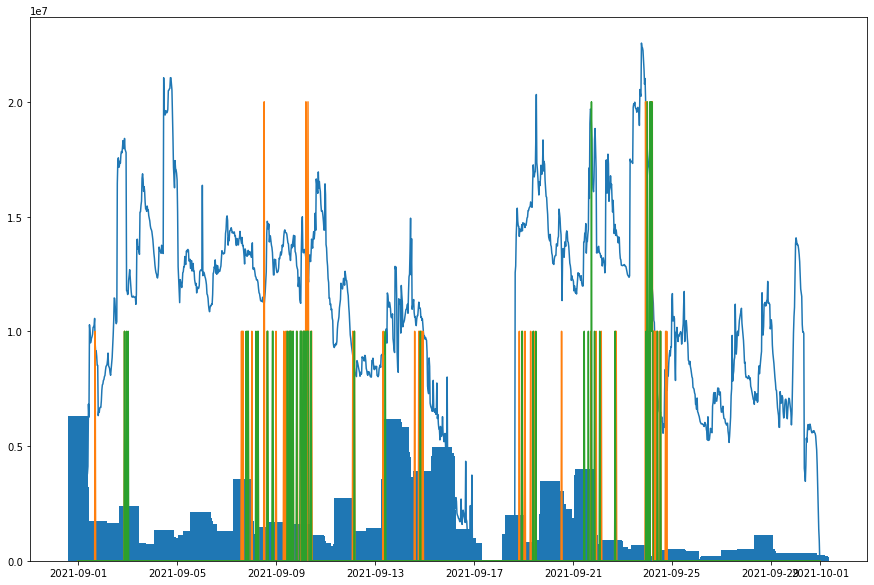

In [28]:
tmp_df['JOBID'] = tmp_df['JOBID'] * 500
plt.figure(figsize=(15, 10))
plt.bar(tmp_df['BEGIN'], tmp_df['JOBID'])
plt.plot(a.index, a[0])
plt.plot(a.index, a['4'])
plt.plot(a.index, a['errorcode'])
# blue line used memory, green bar ce6, orange bar ce5, blue bar jobs began per hour